In [1]:
# IMAGE PROCESSING
import cv2 # OpenCV library
import numpy as np # Numpy library for matricies
import random
import math
from matplotlib import pyplot as plt # Matplotlib library for plotting
from collections import deque
import heapq

random.seed(42)

In [2]:
# General settings
seed = 42
# image_file = "maze1234.png"
image_file = "continuous_maze_2_cropped.jpeg"

# Occupancy map
unsafe_iterations = 3

# BFS
size_of_node_grid = 9
bfs_start_node = 0
bfs_end_node = 99

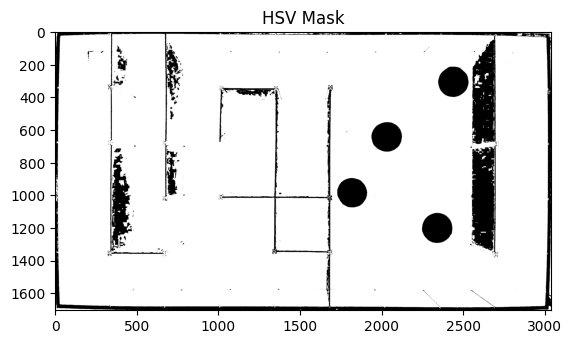

In [3]:
# Loading in the image
image = cv2.imread(image_file)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower = np.array([0, 8, 104]) # 0 0 102
upper = np.array([179, 255, 255]) # 179 255 224

hsv_mask = cv2.inRange(hsv_image, lower, upper)

# Display the mask
plt.figure(1)
plt.imshow(hsv_mask, cmap='gray')
plt.title("HSV Mask")

plt.show()

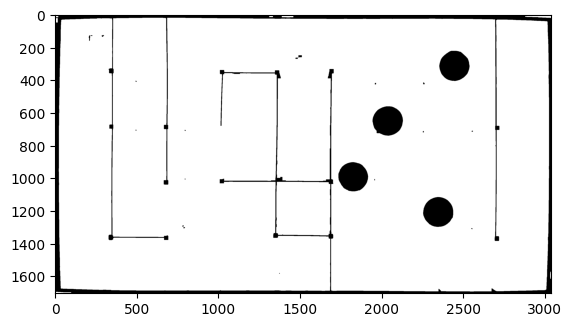

In [4]:
# Applying Erosion + Dilation to the Image

kernel = np.ones((7, 7), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
kernel4 = np.ones((2, 2), np.uint8)
    
# Loading in the image
image = cv2.imread(image_file)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower = np.array([0, 0, 104]) # 0 0 102
upper = np.array([179, 255, 225]) # 179 255 224

hsv_mask = cv2.inRange(hsv_image, lower, upper)

# Applying erosion to generate unsafe area
eroded_image = cv2.erode(hsv_mask, kernel, iterations = unsafe_iterations)

kernel2 = np.ones((4, 4), np.uint8)

# Applying dilation to clean up the image
dilated_image = cv2.dilate(eroded_image, kernel2, iterations = 6)
dilated_image2 = cv2.dilate(dilated_image, kernel3, iterations = 2)
erode_image2 = cv2.erode(dilated_image2, kernel4, iterations = 2)
dilTE123 = cv2.dilate(erode_image2,kernel4,iterations = 2)
erode123 = cv2.erode(dilTE123,kernel4,iterations = 3)

# Displays resulting image
gray_image = plt.imshow(erode123, cmap='gray')
plt.show(gray_image)

# # grayscale_image = hsv_image[:,:,2]

# grayscale_image = cv2.cvtColor(erode123, cv2.COLOR_HSV2BGR)
# grayscale_image = cv2.cvtColor(grayscale_image, cv2.COLOR_BGR2GRAY)

# plt.imshow(grayscale_image)
# plt.show()

# # erodes the white == expanding the black
# image_erode = cv2.erode(grayscale_image, kernel, iterations=unsafe_iterations)

# # XOR: 0 XOR 0 = 0, 1 XOR 1 = 0
# # 0 xor 1 = 1, 1 xor 0 = 1 
# # therefore, the differences will be highlighted, the differences being the new black squares from erosion and 
# # the original image
# red_mask = cv2.bitwise_xor(grayscale_image, image_erode)

# # Red color in BGR format
# # Opposite of red layer since we're gonna be subtracting this from the image 
# # so that white colors are turned into red
# red_layer = np.zeros_like(image)
# red_layer[:, :] = [0, 255, 255] 

# unsafe_area_image = cv2.bitwise_and(red_layer, red_layer, mask=red_mask)

# # image = cv2.subtract(image, unsafe_area_image)

# # Subtract the unsafe area from the original image
# image = cv2.subtract(image, unsafe_area_image)
# plt.imshow(image)

# # # Display the final image with highlighted unsafe areas
# # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# # Display resulting image
# plt.show()

In [5]:
# IMAGE PROCESSING?